In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import datetime
import os.path
import backtrader as bt
import numpy as np
from pprint import pformat
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys
import random

sys.path.append('../..')
from mc.montecarlo import MonteCarlo

# Strategy

In [2]:
class TestStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.042),
        ('rsi_cross_up', 50),
        ('rsi_cross_down', 50),
        ('live', False),
        ('walkforward', None),
    )
        
    def __init__(self):
        self.dataclose = self.datas[0].close
        # To keep track of pending orders and buy price/commission

        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.pp = pp = bt.indicators.PivotPoint(self.data1)
        self.rsi = rsi = bt.indicators.RelativeStrengthIndex()

        # Trim the indicators if we are running live, just need the current one
        if self.params.live:
            pass
        
        self.d = {
            'rsi': bt.indicators.RelativeStrengthIndex(self.datas[0]),
            'pivot': pp,
            'longcross': bt.Or(bt.indicators.CrossUp(self.dataclose, pp()), bt.indicators.CrossUp(rsi, self.p.rsi_cross_up)),
            'longsellcross': bt.indicators.CrossUp(self.dataclose, pp.r2()),
            'shortcross':  bt.Or(bt.indicators.CrossDown(self.dataclose, pp()), bt.indicators.CrossDown(rsi, self.p.rsi_cross_down)),
            'shortsellcross': bt.indicators.CrossDown(self.dataclose, pp.s2()),
        }
        
        if self.params.walkforward:
            self.wfsma = []
            for run in self.params.walkforward:
                params=dict(run['best_insample_param'])
                self.wfsma.append({
                    'rsi': bt.indicators.RelativeStrengthIndex(self.datas[0]),
                    'pivot': bt.indicators.PivotPoint(self.data1),
                    'longcross': bt.indicators.CrossUp(self.dataclose, pp()),
                    'longsellcross': bt.indicators.CrossUp(self.dataclose, pp.r2()),
                    'shortcross':  bt.indicators.CrossDown(self.dataclose, pp()),
                    'shortsellcross': bt.indicators.CrossDown(self.dataclose, pp.s2()),
                    'test_period': run['oos'],
                    'train_param': params,
                }) 

        
    def set_wf_params(self):
        for row in self.wfsma:
            start, end = row['test_period']
            if self.datetime.datetime() >= start and self.datetime.datetime() < end:
                self.d = row
            
    def next(self):

        if self.params.walkforward: self.set_wf_params()
        if self.order: return
        
        if not self.position:
            if  self.d['longcross'] == 1:
                self.order = self.buy() 
                stop_price =  self.d['pivot'].s2 * (1.0 - self.p.stop_loss)
                self.sell(exectype=bt.Order.Stop, price=stop_price)
                
            elif self.d['shortcross'] == 1:
                self.order = self.sell()
                stop_price =  self.d['pivot'].r2 * (1.0 + self.p.stop_loss)
                self.buy(exectype=bt.Order.Stop, price=stop_price)
        else:
            if self.position.size > 0 and self.d['longsellcross'] == 1:
                self.order = self.close()
            elif self.position.size < 0 and self.d['shortsellcross'] == 1:
                self.order = self.close()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            self.bar_executed = len(self)
        # Write down: no pending order
        self.order= None



## Analyzers

In [3]:
class myAnalyzer(bt.Analyzer):
    params=(
        ('printlog', None),
    )
    
    def __init__(self):
        self.equitydf=pd.DataFrame()

    def log(self, txt, dt=None, doprint=False):
        if self.p.printlog or doprint:
            dt= dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}, {txt}')
            
    def start(self):
        self.trade_count = 0
        self.starting_nav= self.strategy.broker.get_value() 
        
        self.num_trades = 0
        self.first_trade_open = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            if order.isbuy():
                self.log(f'BUY CREATE, {self.strategy.dataclose[0]:.2f}')
            elif order.issell():
                self.log(f"SELL CREATE {self.strategy.dataclose[0]:.2f}")
                
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not self.first_trade_open:
            self.first_trade_open = self.strategy.datetime.datetime()
            self.equitydf.at[self.first_trade_open, 'equity'] = self.starting_nav

        if trade.isclosed:
            self.num_trades += 1
            self.equitydf.at[self.strategy.datetime.datetime(), 'equity'] = self.strategy.broker.getvalue()
            
        self.trade_count += 1 # below
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')
    
    def stop(self):
        self.ending_nav = self.strategy.broker.getvalue()
        self.params= self.strategy.params
        self.log(f'''{vars(self.params)} \tEnding Value {self.ending_nav:.2f}''', doprint=True)

    def get_analysis(self):
        
        self.equitydf['net_profit'] = self.equitydf['equity'].diff()

        ret= {  'equitydf':self.equitydf,
                'trade_count': self.trade_count,
                'ending_NAV': self.ending_nav,
                'P&L' : self.ending_nav-self.starting_nav }
        ret.update(**vars(self.params))
        return ret

## Backtest set-up

In [4]:
def get_data(fname_symbol = 'CL', folder_name = '5min', suffix = '5min_20160103_20190405'):
    df = pd.read_parquet(os.path.join('../../data/processed/{}/'.format(folder_name), '{}_{}.parquet'.format(fname_symbol, suffix)))
    df = (df.resample('4h', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
    df.columns = [col_name.lower() for col_name in df.columns]
    df = df.dropna()
    return fname_symbol,df

def set_broker_parameters(cerebro):
    cerebro.broker.setcash(100000.)
    cerebro.broker.setcommission(commission=2.5, margin=6000.0, mult=1000.0, name='CL')
    cerebro.broker.set_slippage_fixed(.01, 
                              slip_open=True, 
                              slip_limit=True, 
                              slip_match=False, 
                              slip_out=True)

def set_analyzers(cerebro):    
    cerebro.addanalyzer(myAnalyzer, printlog=None)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
    cerebro.addanalyzer(bt.analyzers.Transactions)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days, _name='dayreturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, riskfreerate=0,_name='mysharpe',timeframe=bt.TimeFrame.Days)#, compression=30)

def set_opt_analyzers(cerebro):
    cerebro.addanalyzer(myAnalyzer, printlog=None)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Days, _name='dayreturn')

def set_sizers(cerebro):
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)
    
    
def get_periods(start_is, is_duration, oos_duration, wf_offset,wf_cycles):
    periods=[]
    start_is=pd.Timestamp(start_is)
    start_oos=start_is+pd.DateOffset(**is_duration)
    end_oos=start_oos+pd.DateOffset(**oos_duration)
    for i in range(wf_cycles):
        periods.append({'run':i,
                        'is':(start_is, start_oos),
                        'oos':(start_oos, end_oos)})
        start_is+=pd.DateOffset(**wf_offset)
        start_oos+=pd.DateOffset(**wf_offset)
        end_oos+=pd.DateOffset(**wf_offset)
    return periods
    
periods= get_periods(
    start_is = "2017-01-01", 
    is_duration={'months':3}, 
    oos_duration={'months':1},
    wf_offset={'months':1},
    wf_cycles=14
)

#periods

## Optimization

In [5]:
cerebro = bt.Cerebro(maxcpus=1)

start_date = periods[0]['is'][0]
end_date = periods[-1]['is'][1]
print('Start/End: {} - {}'.format(start_date, end_date))

# Add Strategy
opt_args=dict(
    stop_loss = np.arange(0.02, 0.045, 0.01),
    rsi_cross_up = range(50,80, 10),
    rsi_cross_down = range(20,50, 10))

cerebro.optstrategy(TestStrategy, **opt_args)
# cerebro.addstrategy(TestStrategy)

set_broker_parameters(cerebro)

set_opt_analyzers(cerebro)

set_sizers(cerebro)

data_name,df=get_data()


data = bt.feeds.PandasData(dataname = df[start_date:end_date], timeframe=bt.TimeFrame.Minutes, compression=240)

cerebro.adddata(data, name=data_name)
cerebro.resampledata(data, timeframe=bt.TimeFrame.Weeks)


results=cerebro.run(runonce=False)
# cerebro.plot(volume=False, iplot=True, style='candles')

Start/End: 2017-01-01 00:00:00 - 2018-05-01 00:00:00
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 20, 'live': False, 'walkforward': None} 	Ending Value 123971.13
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 30, 'live': False, 'walkforward': None} 	Ending Value 108444.90
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 40, 'live': False, 'walkforward': None} 	Ending Value 108777.33
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 20, 'live': False, 'walkforward': None} 	Ending Value 120527.63
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 30, 'live': False, 'walkforward': None} 	Ending Value 119333.23
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 40, 'live': False, 'walkforward': None} 	Ending Value 110125.30
2018-04-30, {'stop_loss': 0.02, 'rsi_cross_up': 70, 'rsi_cross_down': 20, 'live': False, 'walkforward': None} 	Ending Value 115010.83
2018-04-3

## Select per-period insample winners

In [6]:
# Get in-sample and out-of-sample best parameters with correct pre-allocation
for period in periods:
    # Get the insample time period
    insample_start = period['is'][0]
    insample_end = period['is'][1]
    print('In-Sample Period: {} - {}'.format(insample_start, insample_end))
    
    # Put the best parameters and best profit into a list
    period_netprofit = []
    for [result] in results:
        myAnalysis=result.analyzers.myanalyzer.get_analysis()
        df = myAnalysis['equitydf']
        optim=[(key, myAnalysis[key]) for key in opt_args]
        
        period_profit = df[insample_start:insample_end]['net_profit'].sum()
        print(f'\t{dict(optim)}: {period_profit}')
        period_netprofit.append((optim, period_profit,df))

        
    # Get the best profit parameters
    max_params, max_profit, best_equity = max(period_netprofit, key=lambda x:x[1])
    
    # Add it to the dictionary
    print(f'Best is: {dict(max_params)} with {max_profit} profit\n')
    period['best_insample_param'] = max_params
    period['best_insample_profit'] = max_profit
    period['best_equity'] = best_equity

In-Sample Period: 2017-01-01 00:00:00 - 2017-04-01 00:00:00
	{'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 20}: -3057.0666666666802
	{'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 30}: 1055.0
	{'stop_loss': 0.02, 'rsi_cross_up': 50, 'rsi_cross_down': 40}: 3850.0
	{'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 20}: -4316.799999999988
	{'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 30}: 1055.0
	{'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 40}: 2935.0
	{'stop_loss': 0.02, 'rsi_cross_up': 70, 'rsi_cross_down': 20}: -4316.799999999988
	{'stop_loss': 0.02, 'rsi_cross_up': 70, 'rsi_cross_down': 30}: 1055.0
	{'stop_loss': 0.02, 'rsi_cross_up': 70, 'rsi_cross_down': 40}: 2935.0
	{'stop_loss': 0.03, 'rsi_cross_up': 50, 'rsi_cross_down': 20}: -3596.4333333333343
	{'stop_loss': 0.03, 'rsi_cross_up': 50, 'rsi_cross_down': 30}: 1055.0
	{'stop_loss': 0.03, 'rsi_cross_up': 50, 'rsi_cross_down': 40}: 3850.0
	{'stop_loss': 0.03, 'rsi_cross_up': 6

	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 50, 'rsi_cross_down': 30}: -6993.533333333326
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 50, 'rsi_cross_down': 40}: -3991.333333333314
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 60, 'rsi_cross_down': 20}: -71.80000000000291
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 60, 'rsi_cross_down': 30}: -4122.6666666666715
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 60, 'rsi_cross_down': 40}: -330.4666666666744
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 70, 'rsi_cross_down': 20}: -1212.6666666666715
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 70, 'rsi_cross_down': 30}: -5957.6666666666715
	{'stop_loss': 0.039999999999999994, 'rsi_cross_up': 70, 'rsi_cross_down': 40}: -9991.000000000015
Best is: {'stop_loss': 0.02, 'rsi_cross_up': 60, 'rsi_cross_down': 40} with 7845.800000000032 profit

In-Sample Period: 2017-10-01 00:00:00 - 2018-01-01 00:00:00
	{'stop_loss': 0.02, 'rsi_cross_up': 50, 'r

## Walk-forward Efficiency

In [7]:
# Get in-sample and out-of-sample best parameters with correct pre-allocation
all_walkforward_efficiency = []
all_is_profits = []
all_oos_profits=[]
for period in periods:
    # Get the insample time period
    oos_start, oos_end = period['oos']
    print(f'Out-of-Sample Period: {oos_start} - {oos_end}')

    insample_profit = period['best_insample_profit']
    oos_profit = period['best_equity']['net_profit'][oos_start:oos_end].sum()
    
    insample_annual_profit = 365/ (period['is'][1]-period['is'][0]).days * insample_profit
    oos_annual_profit = 365/(period['oos'][1]-period['oos'][0]).days * oos_profit
 
    # Calculate WFE
    sgn = 1 if insample_profit > 0 else -1
    period['wfe'] = sgn*oos_annual_profit/ insample_annual_profit * 100 
    

    all_walkforward_efficiency.append(period['wfe'])
    all_is_profits.append(insample_annual_profit)
    all_oos_profits.append(oos_annual_profit)
    
    print(f'\t Period Profit IS:{insample_profit:0.2f} / OOS:{oos_profit:0.2f}')
    print(f'\t Annualized Profit IS:{insample_annual_profit:0.2f} / OOS:{oos_annual_profit:0.2f}')
    print(f"\t WFE: {period['wfe']:0.1f}%")

wfe = sum(all_walkforward_efficiency) / len(all_walkforward_efficiency) 


# print(f'Average WFE: {wfe:0.1f}%')
    

wfe2 = 100*sum(all_oos_profits) / sum(all_is_profits) 

print(f'Effective WFE[2]: {wfe2:0.1f}%')

Out-of-Sample Period: 2017-04-01 00:00:00 - 2017-05-01 00:00:00
	 Period Profit IS:3850.00 / OOS:1925.00
	 Annualized Profit IS:15613.89 / OOS:23420.83
	 WFE: 150.0%
Out-of-Sample Period: 2017-05-01 00:00:00 - 2017-06-01 00:00:00
	 Period Profit IS:5775.00 / OOS:2675.00
	 Annualized Profit IS:23683.99 / OOS:31495.97
	 WFE: 133.0%
Out-of-Sample Period: 2017-06-01 00:00:00 - 2017-07-01 00:00:00
	 Period Profit IS:8450.00 / OOS:2417.73
	 Annualized Profit IS:33524.46 / OOS:29415.76
	 WFE: 87.7%
Out-of-Sample Period: 2017-07-01 00:00:00 - 2017-08-01 00:00:00
	 Period Profit IS:7017.73 / OOS:-6043.00
	 Annualized Profit IS:28148.05 / OOS:-71151.45
	 WFE: -252.8%
Out-of-Sample Period: 2017-08-01 00:00:00 - 2017-09-01 00:00:00
	 Period Profit IS:11665.00 / OOS:0.00
	 Annualized Profit IS:46279.62 / OOS:0.00
	 WFE: 0.0%
Out-of-Sample Period: 2017-09-01 00:00:00 - 2017-10-01 00:00:00
	 Period Profit IS:9989.17 / OOS:-3615.33
	 Annualized Profit IS:39630.93 / OOS:-43986.56
	 WFE: -111.0%
Out-of-

## Walk-forward Equity Curve

In [8]:
cerebro = bt.Cerebro()

start_date = periods[0]['oos'][0]
end_date = periods[-1]['oos'][1]
print('Start/End: {} - {}'.format(start_date, end_date))

cerebro.addstrategy(TestStrategy, walkforward=periods)

set_broker_parameters(cerebro)

set_analyzers(cerebro)

set_sizers(cerebro)

data_name,df=get_data()

data = bt.feeds.PandasData(dataname = df[start_date:end_date], timeframe=bt.TimeFrame.Minutes, compression=240)

cerebro.adddata(data, name=data_name)
cerebro.resampledata(data, timeframe=bt.TimeFrame.Weeks)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

[result]=cerebro.run()

Start/End: 2017-04-01 00:00:00 - 2018-06-01 00:00:00
Starting Portfolio Value: 100000.00
2018-05-31, {'stop_loss': 0.042, 'rsi_cross_up': 50, 'rsi_cross_down': 50, 'live': False, 'walkforward': [{'run': 0, 'is': (Timestamp('2017-01-01 00:00:00'), Timestamp('2017-04-01 00:00:00')), 'oos': (Timestamp('2017-04-01 00:00:00'), Timestamp('2017-05-01 00:00:00')), 'best_insample_param': [('stop_loss', 0.02), ('rsi_cross_up', 50), ('rsi_cross_down', 40)], 'best_insample_profit': 3850.0, 'best_equity':                             equity   net_profit
2017-01-09 10:00:00  100000.000000          NaN
2017-03-08 14:00:00  102935.000000  2935.000000
2017-03-31 14:00:00  103850.000000   915.000000
2017-04-19 14:00:00  105775.000000  1925.000000
2017-05-04 10:00:00  108450.000000  2675.000000
2017-06-21 14:00:00  110867.733333  2417.733333
2017-07-27 06:00:00  104824.733333 -6043.000000
2017-09-06 10:00:00  104559.733333  -265.000000
2017-09-14 06:00:00  101995.333333 -2564.400000
2017-09-25 14:00:00  1

Final Portfolio Value: 107150.03


/home/martensdr/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Equity')

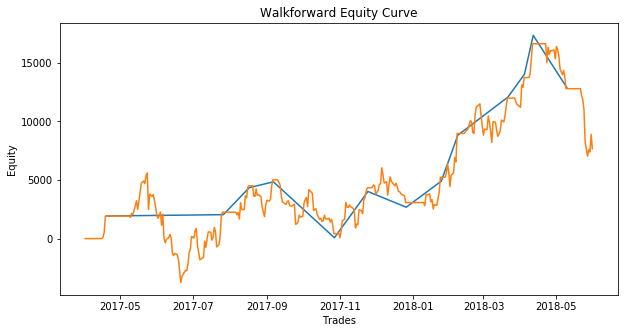

In [9]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
dr = result.analyzers.dayreturn.get_analysis()
df = pd.DataFrame(dr.items()).set_index(0)#.loc[:,1]
cumsum= df.cumsum()
r = result.analyzers.myanalyzer.get_analysis()
plt.figure(figsize=(10,5))
plt.plot(r['equitydf']['net_profit'].cumsum())##cumsum)
plt.plot(cumsum*(r['ending_NAV']-r['P&L']))
plt.title('Walkforward Equity Curve')
plt.xlabel('Trades')
plt.ylabel('Equity')

In [10]:
# Initialize
margin = 5000
mc = MonteCarlo(r['equitydf']['net_profit'].values[1:])

# We will sample with replacement the number of trades per year
# so we need the start and end date to determine how many trades at in a year on average
mc.settings(margin, start_date, end_date)

# Test different levels of equity starting at this value
trial_starting_equity = int(margin * 1.5)

# Run the Monte Carlo
results = mc.run(trial_starting_equity)

ZeroDivisionError: division by zero

In [ ]:
# Put the results in a dataframe so it's nicer to look at in notebook
# Our goal is to get the highest equity below 10% Risk of Ruin
df = pd.DataFrame(index=range(1,len(results)))
count = 1
for result in results:
    df.loc[count, 'equity'] = result['equity']
    df.loc[count, 'is_ruined'] = result['is_ruined']
    df.loc[count, 'is_profitable'] = result['is_profitable']
    df.loc[count, 'returns_pct'] = result['returns_pct']
    df.loc[count, 'drawdown_pct'] = result['drawdown_pct']
    df.loc[count, 'returns_per_drawdown'] = result['returns_per_drawdown']
    count += 1

# Get the recommended values
recommended = df[df['is_ruined'] <= 10].iloc[0]
print('Recommend a starting equity of {}, which has {:0.2}% Risk-of-Ruin, \n\t{:0.0f}% Probability-of-Profit and a {:0.2f} Returns/Drawdown Ratio'.format(
                recommended['equity'], recommended['is_ruined'], 
                recommended['is_profitable'], recommended['returns_per_drawdown']))

if recommended['is_ruined'] > 10 or recommended['returns_per_drawdown'] < 2.0:
    print("Risk Assessment: FAILED")
else:
    print("Risk Assessment: PASSED")

mc_1p5x = recommended['drawdown_pct'] * 1.5
print("MC-Drawdown: {:0.1f}% MC-1.5x-DD: {:0.1f}%".format(recommended['drawdown_pct'], mc_1p5x))

profit = recommended['equity'] * recommended['returns_pct'] / 100
months = (end_date - start_date).days/30
average_monthly_net_profit = profit / months
print("Average monthly net profit: {:0.1f}".format(average_monthly_net_profit))

df